<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S6_2_1_Image_Recognition_with_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconnaissance d'images avec FastAI 

Un des domaines d'application de FastAI est la reconnaissance d'image. Dans cet exercice, nous allons apprendre à notre algorithme à reconnaitre la race d'un chien ou d'un chat sur une photo. 

1. Importez le module ```fastai.vision``` puis à l'intérieur du module ```fastai.metrics``` importez ```error_rate```

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

2. Importez le dataset ```URLs.PETS``` de FastAI via la fonction ```untar_data```. Stockez ceci dans une variable ```path```

In [0]:
path = untar_data(URLs.PETS)
#data = ImageDataBunch.from_folder(path)

2b. Si vous souhaitez avoir plus d'informations sur la fonction ```untar_data```, n'hésitez pas à utiliser ```help(quelque_chose)``` pour les obtenir

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



3. Affichez les différents dossiers qu'il y a dans votre variable ```path```

In [9]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

4. Créez vous un chemin pour le dossier ```annotations``` et un chemin pour le dossier ```images```. Vous pourrez utiliser la forme suivante : ```path/"folder_name"```.

Pour plus d'informations, n'hésitez pas à regarder la librairie [Pathlib](https://docs.python.org/3/library/pathlib.html)

In [16]:
from pathlib import Path
p = Path('/root/.fastai/data/oxford-iiit-pet/')
p = [x for x in p.iterdir() if x.is_dir()]
images = p[1]
annotations = p[0]
images


PosixPath('/root/.fastai/data/oxford-iiit-pet/images')

5. Via la fonction ```get_image_files```,  stockez les images dans une variable _fnames_

In [0]:
fnames = get_image_files(images)
fnames

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_109.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_61.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_55.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_141.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_123.jpg')]

6. Comme vous pouvez le voir, le nom de nos labels sont contenus dans le nom de l'image. Nous allons besoin d'extraire ce nom de label via une expression régulière. Exécutez donc le code suivant pour obtenir le pattern : 

```
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
```

Si vous êtes curieux, n'hésitez pas à regarder les [expressions régulières](https://www.w3schools.com/python/python_regex.asp)

In [19]:
import re
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
fnames = [re.search(pat, str(x)).string for x in fnames]
fnames[0]

'/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_92.jpg'

7. Créez vous maintenant un ```DataBunch```, dans lequel vous pourrez stocker tout ce dont vous avez besoin pour entrainer votre modèle. Regardez toutes les informations ici : [ImageDataBunch](https://docs.fast.ai/vision.data.html). Ajustez la taille de votre image à 224 x 224 pixels

In [20]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_name_re(images, fnames, pat, ds_tfms=get_transforms(), size=224)
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,Birman,samoyed,Egyptian_Mau,basset_hound
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
english_cocker_spaniel,British_Shorthair,boxer,Birman,keeshond
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

8. Regardez un premier batch de données pour vous donner une idée du dataset 

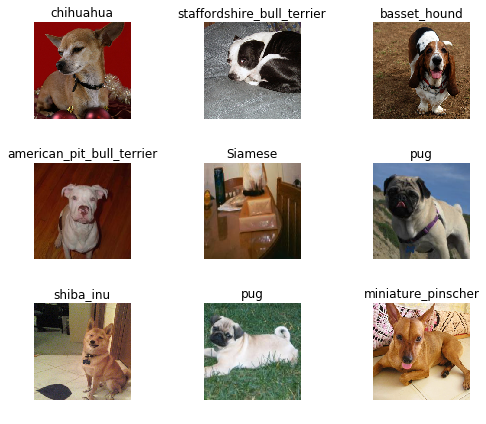

In [21]:
data.show_batch(rows=3, figsize=(7,6))


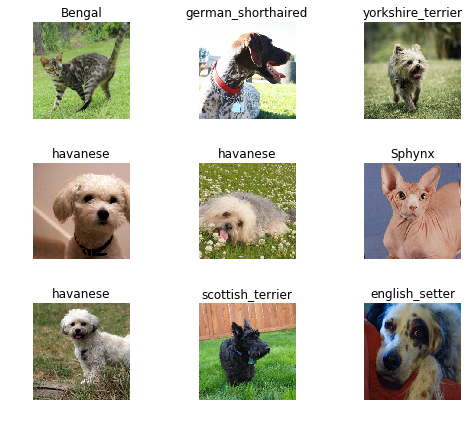

9. Regardez toutes les différentes classes possibles pour ce dataset.

In [22]:
data.y

CategoryList (5912 items)
yorkshire_terrier,Birman,samoyed,Egyptian_Mau,basset_hound
Path: /root/.fastai/data/oxford-iiit-pet/images

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

10. Créez un ```cnn_learner``` avec une architecture ```resnet34``` dans lequel vous ajouterez la metric ```error_rate```

In [23]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)
learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 112MB/s]


Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,Birman,samoyed,Egyptian_Mau,basset_hound
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
english_cocker_spaniel,British_Shorthair,boxer,Birman,keeshond
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3)

11. Regardez l'architecture du modèle resnet34

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

12. Entrainez votre modèle 

In [24]:
learner.fit_one_cycle(3)

13. Regardez vos résultats grâce à ```.show_results()```

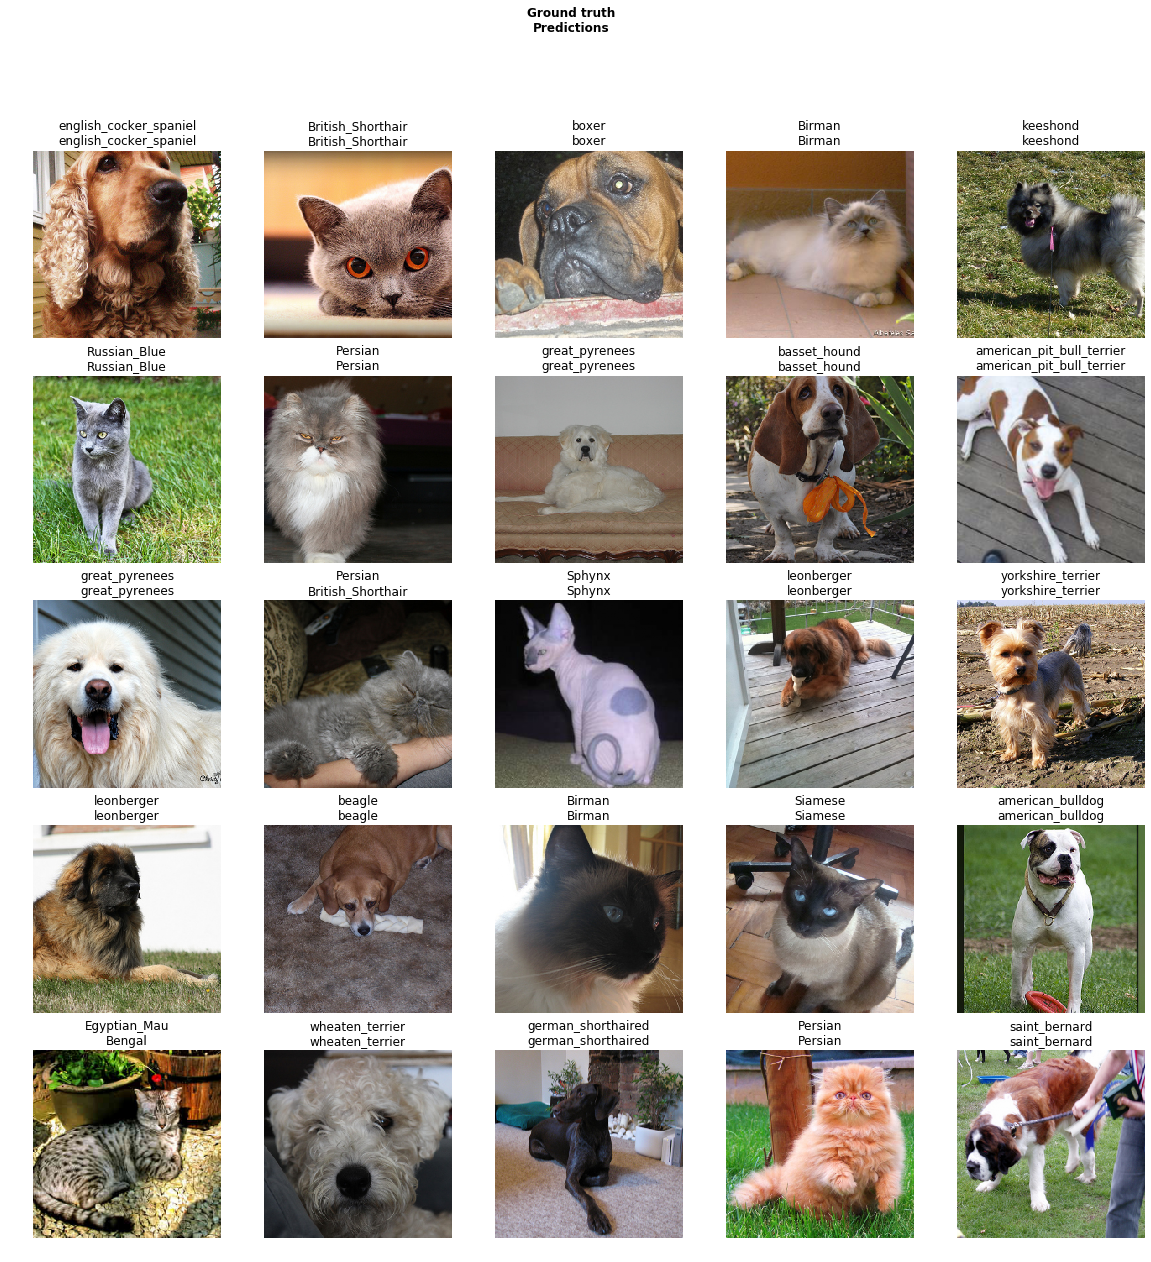

In [25]:
learner.show_results()

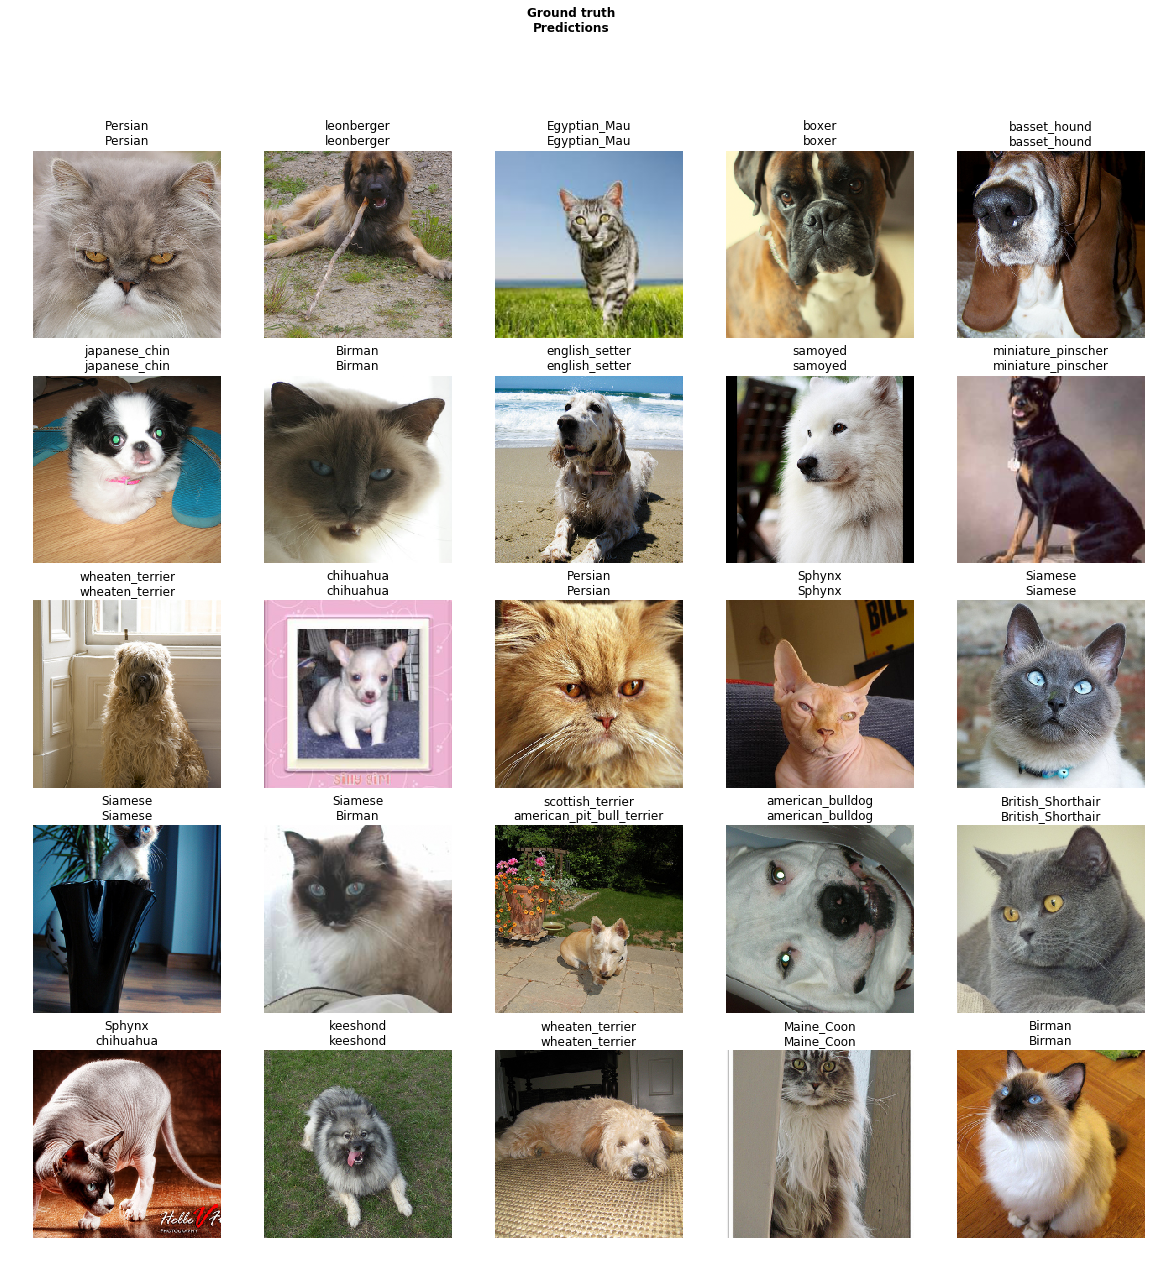



14. Vos scores ont l'air très bien ! Utilisez maintenant un ```ClassificationInterpretion``` pour essayer d'évaluer votre modèle 


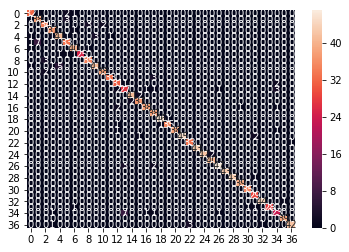

In [27]:
import seaborn as sns
interp = ClassificationInterpretation.from_learner(learner)
sns.heatmap(interp.confusion_matrix(), annot=True, fmt="d")

15. Quelle fonction pouvez vous utiliser pour voir les observations sur lesquelles vous vous êtes le plus trompé ? 

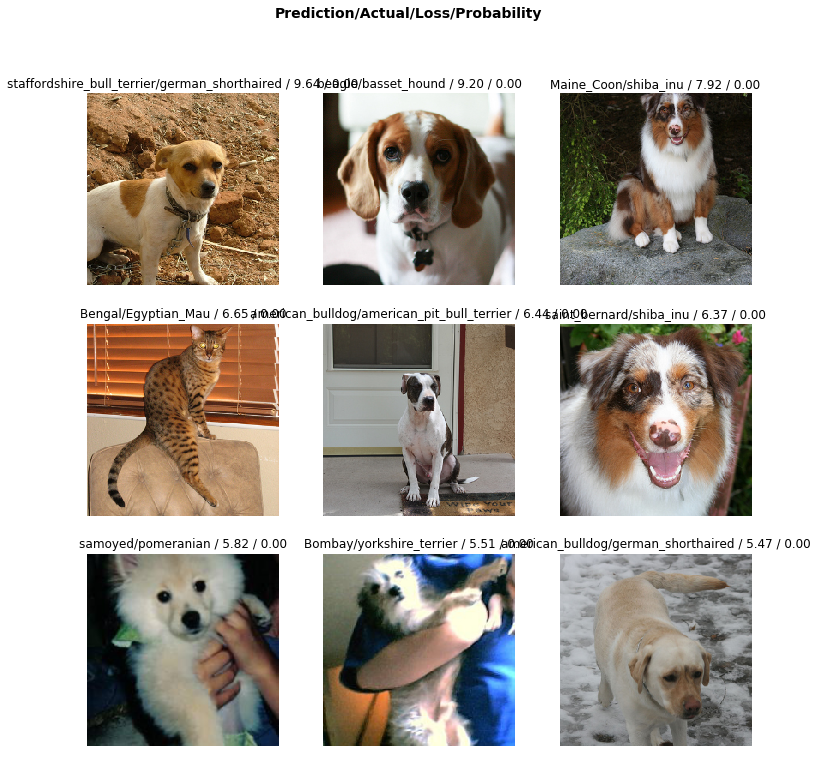

In [28]:
interp.plot_top_losses(k=9)

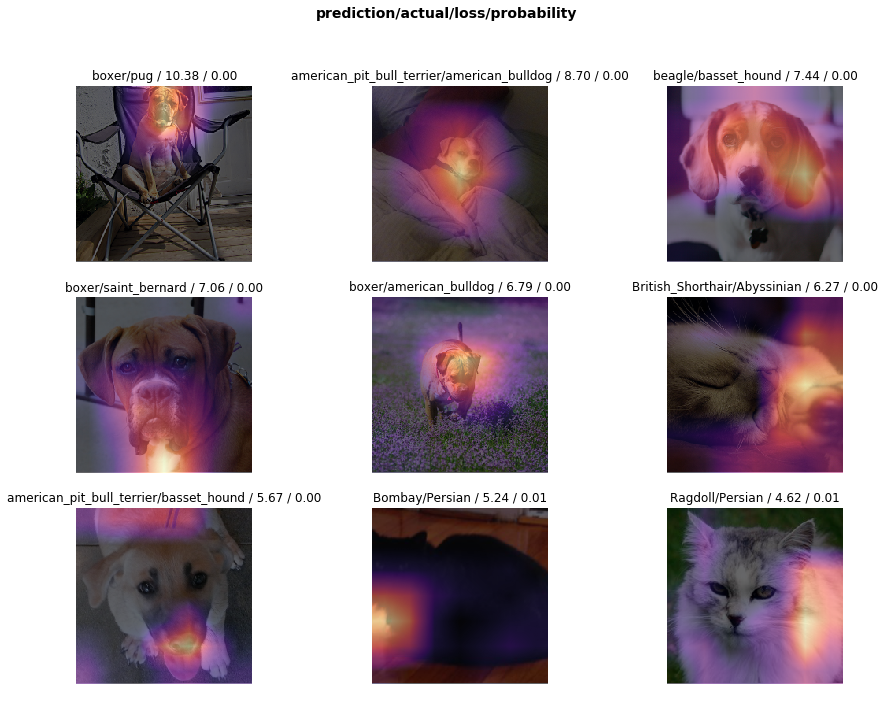